In [95]:
import json, os, sys, collections, itertools,random
from copy import deepcopy as clone
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, matthews_corrcoef, f1_score, classification_report
from sklearn.base import ClassifierMixin, BaseEstimator
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.pipeline import Pipeline
from transformers import RobertaForSequenceClassification, RobertaTokenizer
from transformers import Trainer, TrainingArguments
sys.path.append("../src")

In [2]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {
      'accuracy': acc,
    }

# Load data

In [3]:
commands = {
    0:"nothing",
    1:"put",
    2:"remove",
    3:"use",
    4:"unuse",
    5:"check",
    6:"do",
    7:"move",
}
command2idx = {
        "NOOP": 0,
        "PUT": 1,
        "REMOVE": 2,
        "USE": 3,
        "STOP_USING": 4,
        "CHEF_CHECK": 5,
        "CHEF_DO": 6,
        "MOVE_CONTENTS": 7,
    }
with open("../data/ingredients.json", 'r') as f:
    ingredients = dict(json.load(f))
with open("../data/resources.json", 'r') as f:
    resources = json.load(f)
    resources = [(r["id"], r["name"]) for r in resources if 'children' not in r] + [(r["id"], lst["name"]+'/'+r["name"]) for lst in resources if 'children' in lst for r in lst["children"]]
    resources = {k:v for k,v in resources if not k.startswith("VALID_")}
    res2idx = {k:i for i,k in enumerate(resources.keys())}

In [4]:
arg2idx = res2idx
k=len(arg2idx)+1
with open("../data/arg2idx.json", 'r') as f:
    for w, i in json.load(f).items():
        arg2idx[w.replace('-', '_')] = k
        k += 1

In [5]:
idx2arg = {i:ingredients.get(v,v) for v,i in arg2idx.items()}

# Preprocessing

In [6]:
def triplet_split(s):
    ret = []
    s=s.split()
    for i,t in enumerate(s):
        if i%3==0:
            ret.append([])
        ret[-1].append(t)
    return ret
df = pd.read_csv("seq2seq_4335716.csv")
df["triplet_n"] = df["output_seq"].str.split().str.len()//3
df["triplet_lst"] = df["output_seq"].apply(triplet_split)
df["triplet_first"] = df["triplet_lst"].apply(lambda x:x[0])

df.sample(10)

,input_seq,output_seq,triplet_n,triplet_lst,triplet_first
81,melt butter .,USE TBOWL OVEN_MED PUT I10_d4pRP OVEN_MED CHEF...,3,"[[USE, TBOWL, OVEN_MED], [PUT, I10_d4pRP, OVEN...","[USE, TBOWL, OVEN_MED]"
236,salt and freshly ground black pepper to taste ...,USE TSKILLET COUNTER1 PUT IzPYYTv5e COUNTER1 P...,8,"[[USE, TSKILLET, COUNTER1], [PUT, IzPYYTv5e, C...","[USE, TSKILLET, COUNTER1]"
252,then pour back into bottle and store in fridge .,USE TPOT COUNTER1 STOP_USING TBOWL COUNTER1,2,"[[USE, TPOT, COUNTER1], [STOP_USING, TBOWL, CO...","[USE, TPOT, COUNTER1]"
127,oven about 40 minutes or till chicken is no lo...,MOVE_CONTENTS COUNTER1 SERVE MOVE_CONTENTS STO...,5,"[[MOVE_CONTENTS, COUNTER1, SERVE], [MOVE_CONTE...","[MOVE_CONTENTS, COUNTER1, SERVE]"
217,"in a buttered 11/2 quart casserole , layer the...",MOVE_CONTENTS COUNTER2 COUNTER1 USE TBAKE_DISH...,5,"[[MOVE_CONTENTS, COUNTER2, COUNTER1], [USE, TB...","[MOVE_CONTENTS, COUNTER2, COUNTER1]"
83,add onion and cook until tender .,MOVE_CONTENTS APPL_BLEND STOVE_MEDLOW MOVE_CON...,6,"[[MOVE_CONTENTS, APPL_BLEND, STOVE_MEDLOW], [M...","[MOVE_CONTENTS, APPL_BLEND, STOVE_MEDLOW]"
1,"remove from heat and drain the fat , if any .",MOVE_CONTENTS STOVE_MED FAUCET_OFF USE TSKILLE...,3,"[[MOVE_CONTENTS, STOVE_MED, FAUCET_OFF], [USE,...","[MOVE_CONTENTS, STOVE_MED, FAUCET_OFF]"
214,"mix tomatoes , salt , pepper , sugar and dry m...",USE TBOWL COUNTER1 PUT IzrIHcuDJ COUNTER1 PUT ...,6,"[[USE, TBOWL, COUNTER1], [PUT, IzrIHcuDJ, COUN...","[USE, TBOWL, COUNTER1]"
332,serve this delicious starter with a very chill...,MOVE_CONTENTS COUNTER1 SERVE MOVE_CONTENTS REF...,6,"[[MOVE_CONTENTS, COUNTER1, SERVE], [MOVE_CONTE...","[MOVE_CONTENTS, COUNTER1, SERVE]"
193,heat through and serve .,MOVE_CONTENTS STOVE_MEDHI COUNTER1 MOVE_CONTEN...,5,"[[MOVE_CONTENTS, STOVE_MEDHI, COUNTER1], [MOVE...","[MOVE_CONTENTS, STOVE_MEDHI, COUNTER1]"


<AxesSubplot:ylabel='Frequency'>

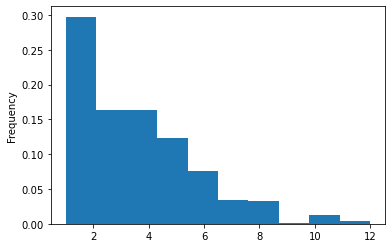

In [7]:
df["triplet_n"].plot.hist(density=True)

In [8]:
sentence_idx = list(df.index)
random.shuffle(sentence_idx)
train_idx = sentence_idx[:int(0.8*len(sentence_idx))]

In [9]:
EXPLODE = False
if EXPLODE:
    df_prep = df.rename(columns={"triplet_lst":"triplet_seq"}).query("triplet_n<6").explode("triplet_seq")
else:
    df_prep = df.rename(columns={"triplet_first":"triplet_seq"})
df_prep.index.name="sentence_index"
df_prep["command"]  =  df_prep["triplet_seq"].apply(lambda x: command2idx[x[0]])
df_prep["arg"]      =  df_prep["triplet_seq"].apply(lambda x: arg2idx[x[1]])
df_prep["resource"] =  df_prep["triplet_seq"].apply(lambda x: res2idx[x[2]])
df_prep=df_prep[["input_seq","triplet_seq",  "command", "arg", "resource"]].reset_index()
df_prep["conditioned_seq"] = df_prep["command"].map(commands) + " <s> " + df_prep["input_seq"]
df_prep["train"]=df_prep["sentence_index"].isin(train_idx)
df_prep

,sentence_index,input_seq,triplet_seq,command,arg,resource,conditioned_seq,train
0,0,brown meat in a big skillet .,"[USE, TSKILLET, STOVE_MED]",3,143,11,use <s> brown meat in a big skillet .,True
1,1,"remove from heat and drain the fat , if any .","[MOVE_CONTENTS, STOVE_MED, FAUCET_OFF]",7,11,21,"move <s> remove from heat and drain the fat , ...",True
2,2,"add the onion , celery and tomaotes .","[MOVE_CONTENTS, STOVE_MED, COUNTER1]",7,11,6,"move <s> add the onion , celery and tomaotes .",True
3,3,stir until well mixed .,"[CHEF_CHECK, LTEXTURE, COUNTER1]",5,126,6,check <s> stir until well mixed .,True
4,4,place a layer of shredded cabbage in the botto...,"[USE, TBAKE_DISH, COUNTER2]",3,130,7,use <s> place a layer of shredded cabbage in t...,False
...,...,...,...,...,...,...,...,...
496,496,add the cabbage and cook the vegetable mixture...,"[PUT, IsxiK2rPw, STOVE_MED]",1,104,11,put <s> add the cabbage and cook the vegetable...,True
497,497,"then cover with hot water , season with walt a...","[USE, TFOIL, STOVE_MED]",3,133,11,"use <s> then cover with hot water , season wit...",False
498,498,add the rice and cook for 15 minutes longer .,"[PUT, IN2e0UIJI, STOVE_MED]",1,51,11,put <s> add the rice and cook for 15 minutes l...,True
499,499,"add the cheese , stir gently and turn off the ...","[PUT, I_qDx9v7e, STOVE_MED]",1,67,11,"put <s> add the cheese , stir gently and turn ...",False


<AxesSubplot:ylabel='Frequency'>

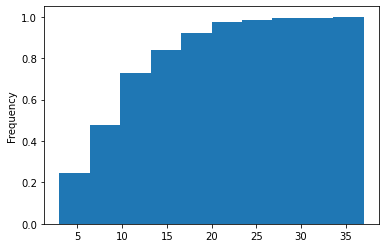

In [10]:
df_prep["input_seq"].str.split().str.len().plot.hist(density=True, cumulative=True)

In [11]:
max_length=20
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [12]:
class SingleInstructionDataset(torch.utils.data.Dataset):
    def __init__(self, df, text, train, target, max_length):
        self.encodings = tokenizer(list(df[df["train"]==train][text]), truncation=True, padding=True, max_length=max_length)
        self.labels = list(df[df["train"]==train][target])

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

# Command Model

In [13]:
# convert our tokenized data into a torch Dataset
command_train_dataset = SingleInstructionDataset(df_prep, "input_seq", True,  "command", max_length)
command_valid_dataset = SingleInstructionDataset(df_prep, "input_seq", False, "command", max_length)

In [14]:
command_names = list(command2idx.keys())
command_model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=len(command_names)).to("cuda")

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

In [15]:
command_training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=30,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
    # but you can specify `metric_for_best_model` argument to change to accuracy or other metric
    logging_steps=200,               # log & save weights each logging_steps
    evaluation_strategy="steps",     # evaluate each `logging_steps`
)
command_trainer = Trainer(
    model=command_model,                 # the instantiated Transformers model to be trained
    args=command_training_args,                  # training arguments, defined above
    train_dataset=command_train_dataset,         # training dataset
    eval_dataset=command_valid_dataset,          # evaluation dataset
    compute_metrics=compute_metrics,     # the callback that computes metrics of interest
)
command_trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
200,1.497800,1.402834,0.524752,0.153500,658.114000
400,0.501300,2.456859,0.534653,0.144800,697.469000
600,0.231000,3.242757,0.504950,0.142900,706.586000


TrainOutput(global_step=750, training_loss=0.6027081775665283, metrics={'train_runtime': 105.2501, 'train_samples_per_second': 7.126, 'total_flos': 179498568960000.0, 'epoch': 30.0, 'init_mem_cpu_alloc_delta': 7978581, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 18306, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 3083448, 'train_mem_gpu_alloc_delta': 2007216640, 'train_mem_cpu_peaked_delta': 154555523, 'train_mem_gpu_peaked_delta': 0})

In [16]:
command_model.save_pretrained("command_model_first_only")

In [17]:
def command_prediction(text):
    # prepare our text into tokenized sequence
    inputs = tokenizer(text, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to("cuda")
    # perform inference to our model
    outputs = command_model(**inputs)
    # get output probabilities by doing softmax
    probs = outputs[0].softmax(1)
    # executing argmax function to get the candidate label
    return command_names[probs.argmax()]
command_prediction("brown meat in large skillet")

'USE'

In [18]:
command_prediction("add the onion , celery and tomaotes .")

'MOVE_CONTENTS'

In [19]:
command_prediction("stir until well mixed .")

'CHEF_CHECK'

In [20]:
command_prediction("add sugar, lemon and spice")

'PUT'

In [ ]:
tokenizer("<s>")

# Models for arg and resource
## Arg Model

In [13]:
arg_names = list(arg2idx.keys())
arg_model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=len(arg_names)).to("cuda")
arg_train_dataset = SingleInstructionDataset(df_prep, "conditioned_seq", True,  "arg", max_length)
arg_valid_dataset = SingleInstructionDataset(df_prep, "conditioned_seq", False, "arg", max_length)
arg_training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=30,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
    # but you can specify `metric_for_best_model` argument to change to accuracy or other metric
    logging_steps=200,               # log & save weights each logging_steps
    evaluation_strategy="steps",     # evaluate each `logging_steps`
    report_to="none"
)
arg_trainer = Trainer(
    model=arg_model,                 # the instantiated Transformers model to be trained
    args=arg_training_args,                  # training arguments, defined above
    train_dataset=arg_train_dataset,         # training dataset
    eval_dataset=arg_valid_dataset,          # evaluation dataset
    compute_metrics=compute_metrics,     # the callback that computes metrics of interest
)
arg_trainer.train()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Step,Training Loss,Validation Loss


RuntimeError: cuda runtime error (710) : device-side assert triggered at /pytorch/aten/src/THC/generic/THCTensorMath.cu:29

In [ ]:
arg_model.save_pretrained("arg_model_first_only")

## Resource Model

In [13]:
resource_names = list(res2idx.keys())
resource_model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=len(resource_names)).to("cuda")
resource_train_dataset = SingleInstructionDataset(df_prep, "conditioned_seq", True,  "resource", max_length)
resource_valid_dataset = SingleInstructionDataset(df_prep, "conditioned_seq", False, "resource", max_length)
resource_training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=30,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
    # but you can specify `metric_for_best_model` argument to change to accuracy or other metric
    logging_steps=200,               # log & save weights each logging_steps
    evaluation_strategy="steps",     # evaluate each `logging_steps`
)
resource_trainer = Trainer(
    model=resource_model,                 # the instantiated Transformers model to be trained
    args=resource_training_args,                  # training arguments, defined above
    train_dataset=resource_train_dataset,         # training dataset
    eval_dataset=resource_valid_dataset,          # evaluation dataset
    compute_metrics=compute_metrics,     # the callback that computes metrics of interest
)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

In [14]:
resource_trainer.train()

Trainer is attempting to log a value of "{0: 'LABEL_0', 1: 'LABEL_1', 2: 'LABEL_2', 3: 'LABEL_3', 4: 'LABEL_4', 5: 'LABEL_5', 6: 'LABEL_6', 7: 'LABEL_7', 8: 'LABEL_8', 9: 'LABEL_9', 10: 'LABEL_10', 11: 'LABEL_11', 12: 'LABEL_12', 13: 'LABEL_13', 14: 'LABEL_14', 15: 'LABEL_15', 16: 'LABEL_16', 17: 'LABEL_17', 18: 'LABEL_18', 19: 'LABEL_19', 20: 'LABEL_20', 21: 'LABEL_21', 22: 'LABEL_22', 23: 'LABEL_23', 24: 'LABEL_24', 25: 'LABEL_25', 26: 'LABEL_26', 27: 'LABEL_27', 28: 'LABEL_28', 29: 'LABEL_29', 30: 'LABEL_30', 31: 'LABEL_31', 32: 'LABEL_32', 33: 'LABEL_33', 34: 'LABEL_34', 35: 'LABEL_35', 36: 'LABEL_36', 37: 'LABEL_37', 38: 'LABEL_38', 39: 'LABEL_39', 40: 'LABEL_40', 41: 'LABEL_41', 42: 'LABEL_42', 43: 'LABEL_43', 44: 'LABEL_44', 45: 'LABEL_45', 46: 'LABEL_46', 47: 'LABEL_47', 48: 'LABEL_48', 49: 'LABEL_49', 50: 'LABEL_50', 51: 'LABEL_51', 52: 'LABEL_52', 53: 'LABEL_53', 54: 'LABEL_54', 55: 'LABEL_55', 56: 'LABEL_56', 57: 'LABEL_57', 58: 'LABEL_58', 59: 'LABEL_59', 60: 'LABEL_60', 61

Step,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
200,3.339400,2.512432,0.376238,0.144300,699.819000
400,1.361600,2.654374,0.475248,0.138600,728.935000
600,0.598200,3.005630,0.475248,0.139300,725.256000


TrainOutput(global_step=750, training_loss=1.4422149353027345, metrics={'train_runtime': 101.364, 'train_samples_per_second': 7.399, 'total_flos': 179649169920000.0, 'epoch': 30.0, 'init_mem_cpu_alloc_delta': 7980534, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 18306, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 3110044, 'train_mem_gpu_alloc_delta': 2008889856, 'train_mem_cpu_peaked_delta': 154524435, 'train_mem_gpu_peaked_delta': 0})

In [16]:
resource_model.save_pretrained("resource_model_first_only")

# Bag of words model for ingredients

In [91]:
X_train = df_prep.query("train")["conditioned_seq"]
X_test = df_prep.query("not train")["conditioned_seq"]
y_train = df_prep.query("train")["arg"]
y_test = df_prep.query("not train")["arg"]

In [129]:
from copy import deepcopy as clone
from sklearn.base import ClassifierMixin, BaseEstimator
from sklearn.pipeline import Pipeline

class ConditionedTextClassifier(ClassifierMixin):
    def __init__(self, conditions, model, condition_sep=' <s> '):
        self.condition_sep=condition_sep
        self.conditions = {}
        for c in conditions:
            self.conditions[c] = clone(model)
    def _filter_condition(self, X,y=None,c=None):
        if y is None:
            y = [None]*len(X)
        if c is None:
            raise SyntaxError("condition cannot be None")
        IXY = [s.split(self.condition_sep, 1) for s in X]
        IXY = [(yy[0], xx[1], yy[1]) for xx,yy in zip(IXY,enumerate(y)) if xx[0]==c]
        if len(IXY)==0:
            return [],[],[]
        ind, X,y = zip(*IXY)
        return ind, X, y
    def fit(self, X, y):
        for c in self.conditions:
            ind_c, X_c, y_c = self._filter_condition(X,y,c)
            if len(X_c)>0:
                self.conditions[c].fit(X_c, y_c)
    def predict(self, X):
        ret = []
        for c in self.conditions:
            ind_c, X_c, y_c = self._filter_condition(X, c=c)
            if len(X_c)>0:
                y_c = self.conditions[c].predict(X_c)
                ret.extend(list(zip(ind_c, y_c)))
        ret = [y for i,y in sorted(ret)]
        return ret
    
base_model = Pipeline([
    ("vec", CountVectorizer(min_df=1, max_df=0.7, binary=True)),
#     ("vec", TfidfVectorizer(min_df=1, max_df=0.7)),
#     ("model", LogisticRegression()),
    ("model", LogisticRegression(dual=True, solver='liblinear')),
])

arg_model = ConditionedTextClassifier(list(commands.values()), base_model)
arg_model.fit(X_train, y_train)
y_pred = arg_model.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.37623762376237624


In [93]:
# arg_model = Pipeline([
# #     ("vec", CountVectorizer(min_df=1, max_df=0.7, binary=True)),
#     ("vec", TfidfVectorizer(min_df=1, max_df=0.7)),
# #     ("model", LogisticRegression()),
#     ("model", LogisticRegression(dual=True, solver='liblinear')),
# ])
# arg_model.fit(X_train, y_train)
# y_pred = arg_model.predict(X_test)
# print(accuracy_score(y_test, y_pred))

0.2376237623762376


# Evaluation

In [60]:
resource_names = list(res2idx.keys())
resource_model = RobertaForSequenceClassification.from_pretrained("resource_model_first_only", num_labels=len(resource_names)).to("cuda")

In [61]:
command_names = list(command2idx.keys())
command_model = RobertaForSequenceClassification.from_pretrained("command_model_first_only", num_labels=len(command_names)).to("cuda")

In [80]:
def prediction(text):
    # COMMAND MODEL
    inputs = tokenizer(text, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to("cuda")
    outputs = command_model(**inputs)
    probs = outputs[0].softmax(1)
    cmd_idx = probs.argmax()
    command = command_names[cmd_idx]
    #RESOURCE MODEL
    text = commands[int(cmd_idx.to('cpu'))] + " </s> " + text
    inputs = tokenizer(text, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to("cuda")
    outputs = resource_model(**inputs)
    probs = outputs[0].softmax(1)
    res_idx = probs.argmax()
    res = resource_names[res_idx]
    arg = idx2arg[arg_model.predict([text])[0]]

    return (command, arg, res)

def pred_command(text):
    inputs = tokenizer(text, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to("cuda")
    outputs = command_model(**inputs)
    probs = outputs[0].softmax(1)
    return int(probs.argmax())

def pred_resource(text):
    inputs = tokenizer(text, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to("cuda")
    outputs = resource_model(**inputs)
    probs = outputs[0].softmax(1)
    ret = int(probs.argmax())
    if idx2arg[ret][-1].isdigit():
        ret=res2idx[idx2arg[ret][:-1]+'1']
    return ret

def pred_arg(text):
    return arg_model.predict([text])[0]

In [89]:
prediction("use skillet to fry chicken")

('USE', 'COUNTER1', 'STOVE_MEDHI')

In [123]:
df_prep["pred_command"] = df_prep["input_seq"].apply(pred_command)
df_prep["pred_resource"] = df_prep["conditioned_seq"].apply(pred_resource)
df_prep["pred_arg"] = df_prep["conditioned_seq"].apply(pred_arg)
df_prep["combined"]=df_prep.apply(lambda r: f"{r['command']}~{r['arg']}~{r['resource']}",axis=1)
df_prep["pred_combined"]=df_prep.apply(lambda r: f"{r['pred_command']}~{r['pred_arg']}~{r['pred_resource']}",axis=1)

In [124]:
df_prep["triplet_seq"] = df_prep["triplet_seq"].apply(tuple)

In [125]:
# accuracy_score(df_prep["triplet_seq"].apply(str), df_prep["pred"].apply(str))

In [126]:
df_test=df_prep.query("not train")
# accuracy_score(df_test["triplet_seq"].apply(str), df_test["pred"].apply(str))

In [127]:
df_test

,sentence_index,input_seq,triplet_seq,command,arg,resource,conditioned_seq,train,pred_command,pred_resource,pred_arg,combined,pred_combined
4,4,place a layer of shredded cabbage in the botto...,"(USE, TBAKE_DISH, COUNTER2)",3,130,7,use <s> place a layer of shredded cabbage in t...,False,3,6,130,3~130~7,3~130~6
11,11,"combine meat , spinach , cheese and seasonings .","(MOVE_CONTENTS, STOVE_MEDLOW, STOVE_MED)",7,10,11,"move <s> combine meat , spinach , cheese and s...",False,7,11,6,7~10~11,7~6~11
17,17,"in a food processor , puree the chopped tomato...","(MOVE_CONTENTS, APPL_PROCESSOR, COUNTER1)",7,3,6,"move <s> in a food processor , puree the chopp...",False,7,6,11,7~3~6,7~11~6
22,22,process on medium speed until smooth .,"(CHEF_CHECK, LTEXTURE, APPL_BLEND)",5,126,4,check <s> process on medium speed until smooth .,False,7,4,126,5~126~4,7~126~4
25,25,remove cover and continue baking for 10 minute...,"(STOP_USING, TFOIL, OVEN_MED)",4,133,15,unuse <s> remove cover and continue baking for...,False,4,15,140,4~133~15,4~140~15
...,...,...,...,...,...,...,...,...,...,...,...,...,...
465,465,serve hot .,"(MOVE_CONTENTS, COUNTER1, SERVE)",7,6,0,move <s> serve hot .,False,7,0,6,7~6~0,7~6~0
482,482,"in large skillet , over medium heat , melt mar...","(USE, TSKILLET, STOVE_MED)",3,143,11,"use <s> in large skillet , over medium heat , ...",False,3,11,143,3~143~11,3~143~11
485,485,"stir in corn , egg beater with cheese , parsle...","(PUT, IrXTUISnn, STOVE_MED)",1,101,11,"put <s> stir in corn , egg beater with cheese ...",False,1,11,101,1~101~11,1~101~11
497,497,"then cover with hot water , season with walt a...","(USE, TFOIL, STOVE_MED)",3,133,11,"use <s> then cover with hot water , season wit...",False,3,11,137,3~133~11,3~137~11


In [128]:
for c in ["command", "resource", "arg", "combined"]:
    print ("="*20 + ">" +  c + "<"+ "="*20)
    print (classification_report(df_test[c], df_test["pred_"+c]))


====================>command<====================
              precision    recall  f1-score   support

           1       0.92      0.92      0.92        24
           2       1.00      1.00      1.00         1
           3       0.80      0.95      0.87        21
           4       1.00      0.75      0.86         4
           5       1.00      0.50      0.67        10
           7       0.86      0.90      0.88        41

    accuracy                           0.87       101
   macro avg       0.93      0.84      0.87       101
weighted avg       0.88      0.87      0.87       101

====================>resource<====================
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           2       0.50      1.00      0.67         1
           4       1.00      1.00      1.00         4
           6       0.85      0.91      0.88        32
           7       0.00      0.00      0.00         4
           9       0.92      1.

/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
